## Load data from kaggle

In [6]:
!pip install kaggle -q
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle competitions download -c plant-pathology-2020-fgvc7

100% 778M/779M [00:34<00:00, 25.5MB/s]
100% 779M/779M [00:34<00:00, 23.7MB/s]


In [8]:
!unzip -q /content/plant-pathology-2020-fgvc7.zip

In [9]:
!pip -q install tensorflow
!pip install -q keras

# Data preparation

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.resnet50  import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [11]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [12]:
SEED = 2007
BATCH_SIZE = 64
TARGET = ['healthy', 'multiple_diseases',	'rust',	'scab']


np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [13]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')

In [14]:
test_df['image_path'] = '/content/images/' + test_df['image_id'] + '.jpg'
train_df['image_path'] = '/content/images/' + train_df['image_id'] + '.jpg'

In [15]:
n_train = int(len(train_df)*0.8)

In [16]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [17]:
train_ds = train_gen.flow_from_dataframe(train_df.iloc[:n_train, :],
                                         x_col='image_path',
                                         y_col=TARGET,
                                         class_mode='raw',
                                         batch_size=BATCH_SIZE,
                                         seed=SEED)
val_ds = test_gen.flow_from_dataframe(train_df.iloc[n_train:, :],
                                      x_col='image_path',
                                      y_col=TARGET,
                                      class_mode='raw',
                                      batch_size=BATCH_SIZE,
                                      seed=SEED,
                                      shuffle=False)
test_ds = test_gen.flow_from_dataframe(test_df, x_col='image_path',
                                        class_mode=None,
                                        batch_size=BATCH_SIZE,
                                        seed=SEED,
                                        shuffle=False)

Found 1456 validated image filenames.
Found 365 validated image filenames.
Found 1821 validated image filenames.


# Tuning

In [18]:
def train_model(lr_tl=0.001, lr_ft=1e-5, drop_rate=0,
                inner_size=(224,224,3), n_epoch=10, fine_tune=False):
    """
    Train parameters of model.

    Args:
        lr_tl: Learning rate for transfer learning.
        model_path: Learning rate for fine tuning.
        drop_rate: Rate of dropout layer.
        inner_size: Size of the inner layer.
        n_epoch: Number of epoches for training.

    Return:
        History of model training.
    """

# Create base model
    base_model = ResNet50(weights='imagenet', input_shape=inner_size, include_top=False)
    base_model.trainable = False
    # Create a new model on top.
    inputs = keras.Input(shape=inner_size)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(drop_rate)(x)
    outputs = keras.layers.Dense(4, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    print('====== Strart transfer-learning ======')
    # Transfer-learning train
    model.compile(
                  optimizer=keras.optimizers.Adam(lr_tl),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy()],
                  )
    tl_history = model.fit(train_ds, epochs=n_epoch, validation_data=val_ds)
    if fine_tune:
        print('====== Strart fine-tuning ======')
        # Fine-tuning train
        base_model.trainable=True

        model.compile(
                      optimizer=keras.optimizers.Adam(lr_ft),
                      loss=keras.losses.CategoricalCrossentropy(),
                      metrics=[keras.metrics.CategoricalAccuracy()],
                      )
        fn_history = model.fit(train_ds, epochs=n_epoch, validation_data=val_ds)
        return fn_history
    return tl_history

In [19]:
def plot_history(history):
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Tune leraning rate of transfer-learning

In [20]:
lr_tl_list = [3e-4, 0.001, 0.01]
lr_tune_hist = {}
for lr in lr_tl_list:
    lr_tune_hist[lr] = train_model(lr_tl=lr)

94765736/94765736 [==============================] - 5s 0us/step
====== Strart transfer-learning ======
Epoch 1/10
23/23 [==============================] - 76s 3s/step - loss: 1.3526 - categorical_accuracy: 0.3372 - val_loss: 1.1699 - val_categorical_accuracy: 0.4356
Epoch 2/10
23/23 [==============================] - 61s 3s/step - loss: 1.0356 - categorical_accuracy: 0.5735 - val_loss: 0.9493 - val_categorical_accuracy: 0.6521
Epoch 3/10
23/23 [==============================] - 60s 3s/step - loss: 0.8542 - categorical_accuracy: 0.7218 - val_loss: 0.8210 - val_categorical_accuracy: 0.7370
Epoch 4/10
23/23 [==============================] - 58s 3s/step - loss: 0.7482 - categorical_accuracy: 0.7837 - val_loss: 0.7450 - val_categorical_accuracy: 0.7589
Epoch 5/10
23/23 [==============================] - 62s 3s/step - loss: 0.6789 - categorical_accuracy: 0.7995 - val_loss: 0.6920 - val_categorical_accuracy: 0.7863
Epoch 6/10
23/23 [==============================] - 58s 3s/step - loss: 0.62

						<<<<<<<< History of model with lr=0.0003 >>>>>>>>


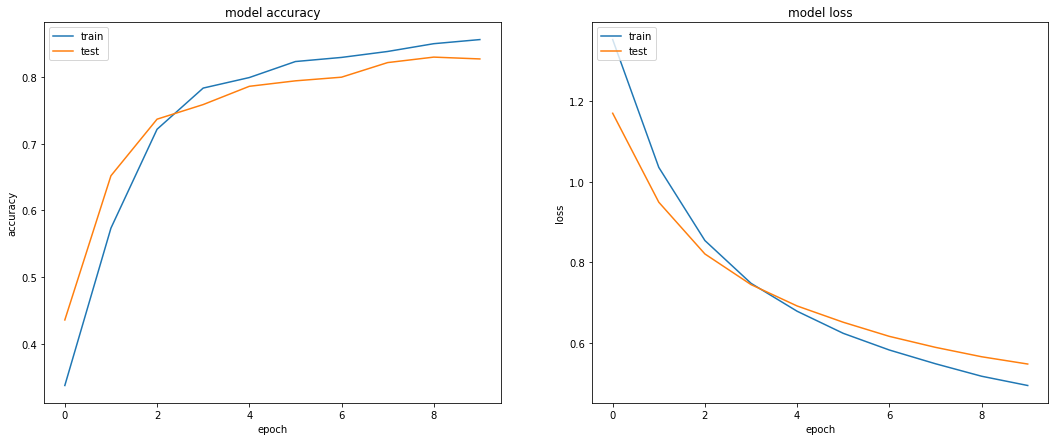

Final valid accuracy=0.827

						<<<<<<<< History of model with lr=0.001 >>>>>>>>


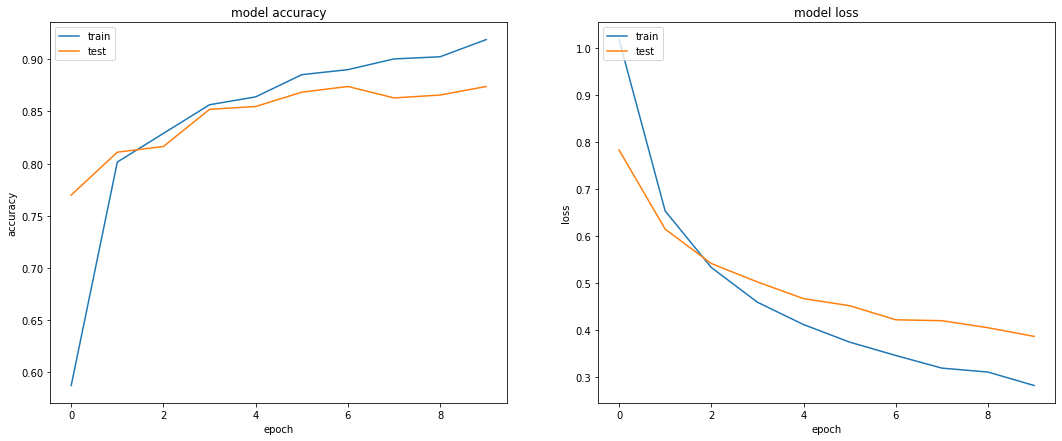

Final valid accuracy=0.874

						<<<<<<<< History of model with lr=0.01 >>>>>>>>


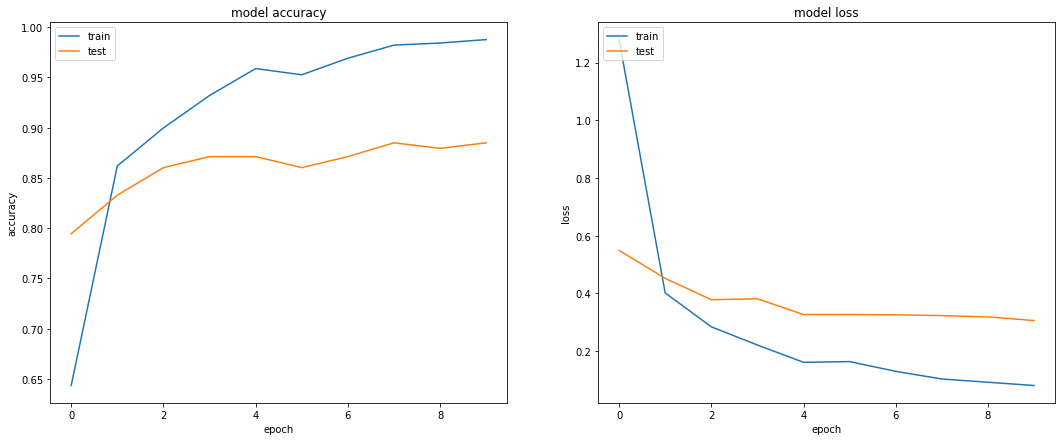

Final valid accuracy=0.885



In [21]:
for lr in lr_tune_hist.keys():
  print(f'\t\t\t\t\t\t<<<<<<<< History of model with lr={lr} >>>>>>>>')
  plot_history(lr_tune_hist[lr])
  val_acc = lr_tune_hist[lr].history['val_categorical_accuracy'][-1]
  print(f'Final valid accuracy={round(val_acc, 3)}\n')

**Training with leraning rate 0.01 shows best accuracy (0.885).**

## Tune leraning rate of fine-tuning.

In [22]:
lr_ft_list = [3e-6, 1e-5, 1e-4]
fn_tune_hist = {}
for lr in lr_ft_list:
    fn_tune_hist[lr] = train_model(lr_tl=0.01, lr_ft=lr, fine_tune=True)

====== Strart transfer-learning ======
Epoch 1/10
23/23 [==============================] - 65s 3s/step - loss: 1.2164 - categorical_accuracy: 0.6319 - val_loss: 0.5908 - val_categorical_accuracy: 0.7973
Epoch 2/10
23/23 [==============================] - 59s 3s/step - loss: 0.3942 - categorical_accuracy: 0.8551 - val_loss: 0.4030 - val_categorical_accuracy: 0.8356
Epoch 3/10
23/23 [==============================] - 59s 3s/step - loss: 0.3081 - categorical_accuracy: 0.8887 - val_loss: 0.3856 - val_categorical_accuracy: 0.8630
Epoch 4/10
23/23 [==============================] - 59s 3s/step - loss: 0.2252 - categorical_accuracy: 0.9327 - val_loss: 0.3537 - val_categorical_accuracy: 0.8712
Epoch 5/10
23/23 [==============================] - 63s 3s/step - loss: 0.1818 - categorical_accuracy: 0.9492 - val_loss: 0.3384 - val_categorical_accuracy: 0.8575
Epoch 6/10
23/23 [==============================] - 60s 3s/step - loss: 0.1499 - categorical_accuracy: 0.9567 - val_loss: 0.3113 - val_catego

						<<<<<<<< History of model with lr=3e-06 >>>>>>>>


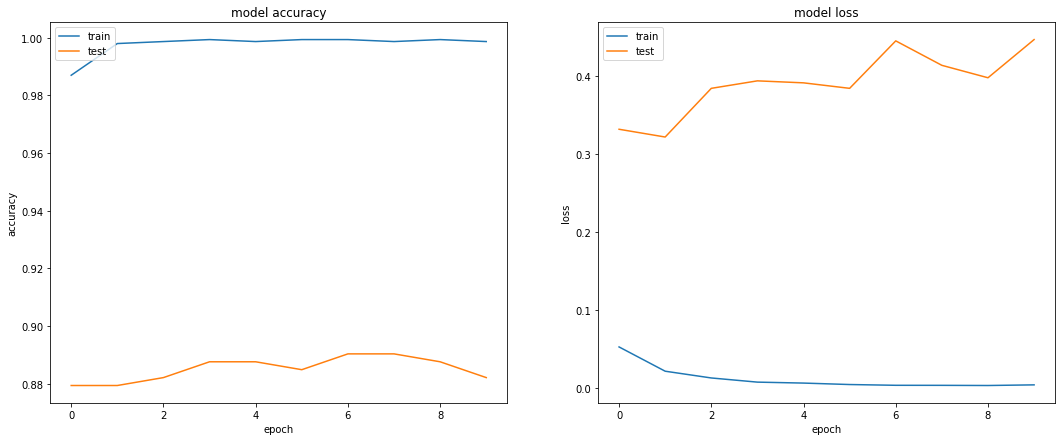

Final valid accuracy=0.882

						<<<<<<<< History of model with lr=1e-05 >>>>>>>>


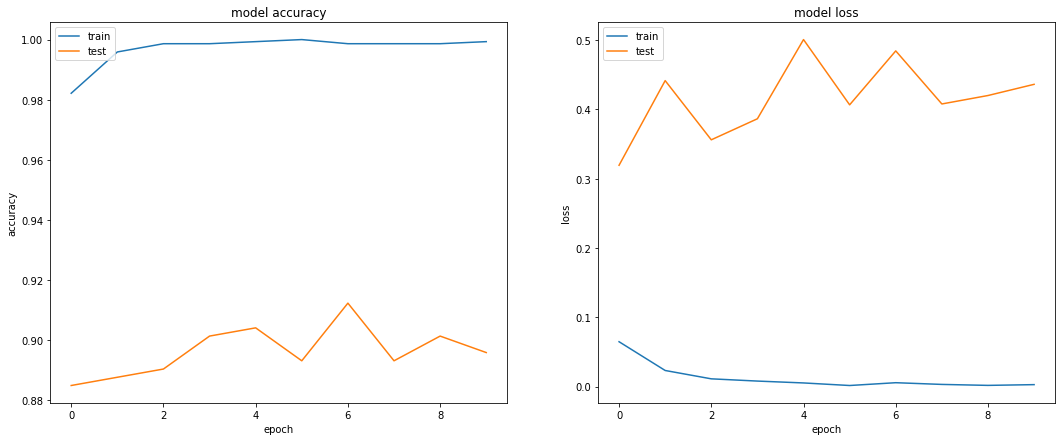

Final valid accuracy=0.896

						<<<<<<<< History of model with lr=0.0001 >>>>>>>>


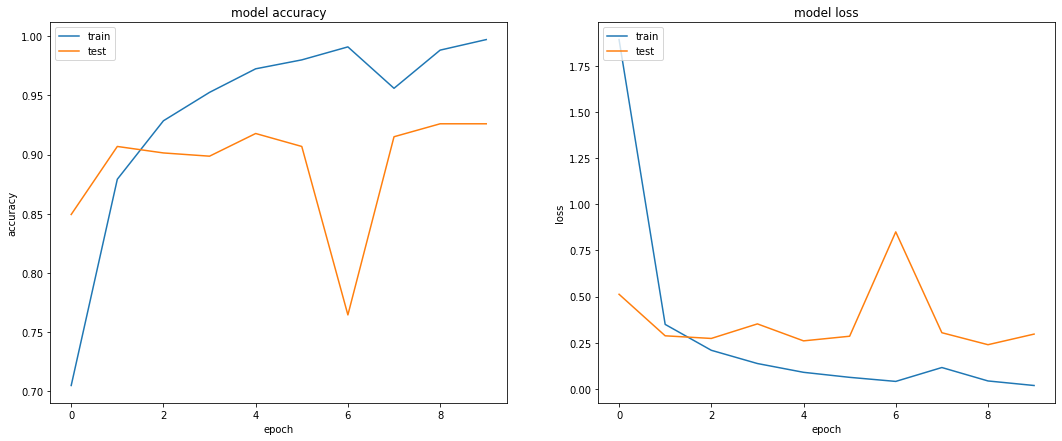

Final valid accuracy=0.926



In [23]:
for lr in fn_tune_hist.keys():
  print(f'\t\t\t\t\t\t<<<<<<<< History of model with lr={lr} >>>>>>>>')
  plot_history(fn_tune_hist[lr])
  val_acc = fn_tune_hist[lr].history['val_categorical_accuracy'][-1]
  print(f'Final valid accuracy={round(val_acc, 3)}\n')

**Training with leraning rate 0.0001 shows best accuracy (0.926).**

## Tune image size

In [ ]:
size_list = [(200,200,3), (224,224,3), (299,299,3)]
size_hist = {}
for size in size_list:
    size_hist[size] = train_model(lr_tl=0.01, lr_ft=1e-4, inner_size=size,
                                  fine_tune=True)

83683744/83683744 [==============================] - 5s 0us/step
====== Strart transfer-learning ======
Epoch 1/10
23/23 [==============================] - 78s 3s/step - loss: 1.1580 - categorical_accuracy: 0.5893 - val_loss: 0.7670 - val_categorical_accuracy: 0.7068
Epoch 2/10
23/23 [==============================] - 61s 3s/step - loss: 0.6338 - categorical_accuracy: 0.7651 - val_loss: 0.6462 - val_categorical_accuracy: 0.7918
Epoch 3/10
23/23 [==============================] - 61s 3s/step - loss: 0.5272 - categorical_accuracy: 0.8152 - val_loss: 0.5762 - val_categorical_accuracy: 0.8055
Epoch 4/10
23/23 [==============================] - 62s 3s/step - loss: 0.4498 - categorical_accuracy: 0.8379 - val_loss: 0.5529 - val_categorical_accuracy: 0.8137
Epoch 5/10
23/23 [==============================] - 60s 3s/step - loss: 0.4243 - categorical_accuracy: 0.8537 - val_loss: 0.5943 - val_categorical_accuracy: 0.7918
Epoch 6/10
23/23 [==============================] - 60s 3s/step - loss: 0.44

						<<<<<<<< History of model with size=(150, 150, 3) >>>>>>>>


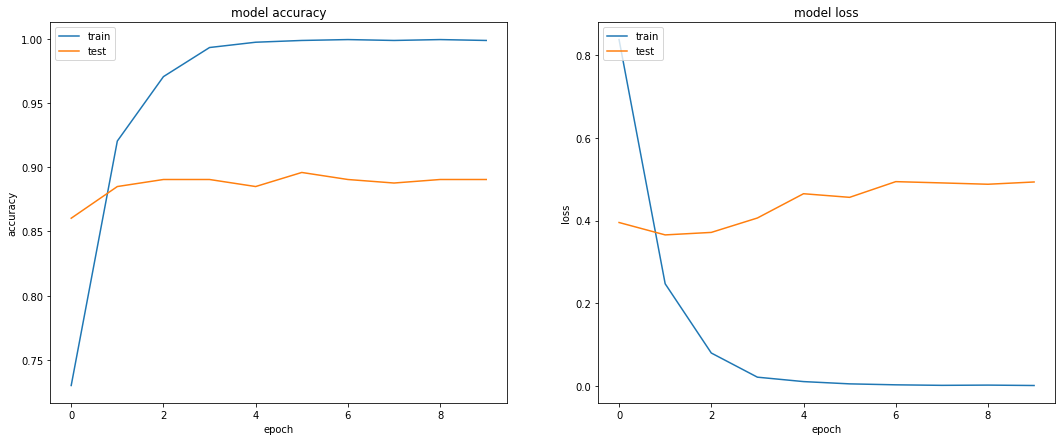

Final valid accuracy=0.89

						<<<<<<<< History of model with size=(256, 256, 3) >>>>>>>>


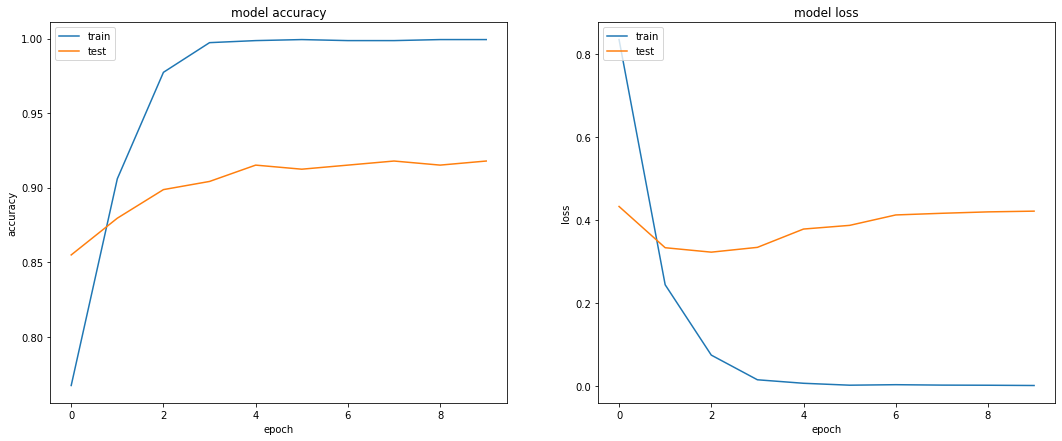

Final valid accuracy=0.918

						<<<<<<<< History of model with size=(299, 299, 3) >>>>>>>>


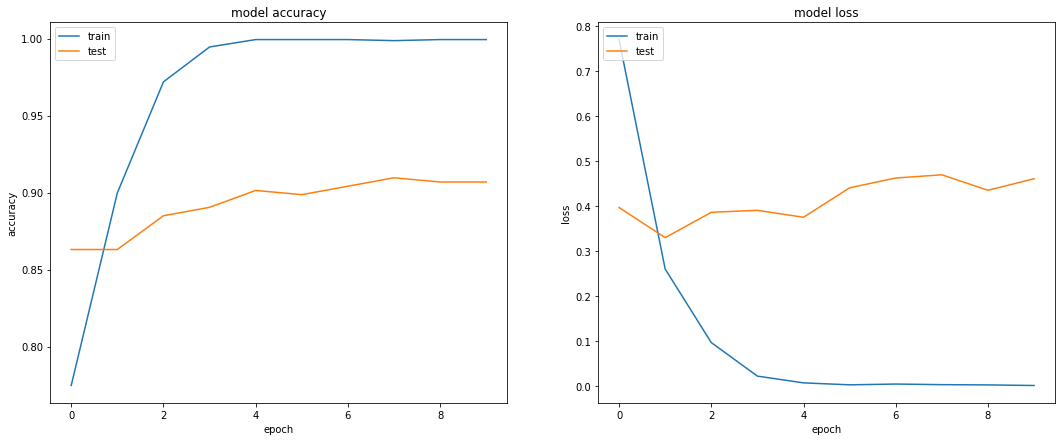

Final valid accuracy=0.907



In [ ]:
for size in size_hist.keys():
  print(f'\t\t\t\t\t\t<<<<<<<< History of model with size={size} >>>>>>>>')
  plot_history(size_hist[size])
  val_acc = size_hist[size].history['val_categorical_accuracy'][-1]
  print(f'Final valid accuracy={round(val_acc, 3)}\n')

**Training with inner size (256,256,3) shows best accuracy (0.918).**

## Tune Dropout layer rate

In [ ]:
dropout_list = [0, 0.2, 0.4]
dropout_hist = {}
for rate in dropout_list:
    dropout_hist[rate] = train_model(lr_tl=0.01, lr_ft=1e-4, inner_size=(256,256,3),
                                  fine_tune=True)

Epoch 1/10
23/23 [==============================] - 64s 3s/step - loss: 1.1460 - categorical_accuracy: 0.6147 - val_loss: 0.9556 - val_categorical_accuracy: 0.6575
Epoch 2/10
23/23 [==============================] - 60s 3s/step - loss: 0.6600 - categorical_accuracy: 0.7603 - val_loss: 0.6375 - val_categorical_accuracy: 0.7836
Epoch 3/10
23/23 [==============================] - 58s 3s/step - loss: 0.5412 - categorical_accuracy: 0.7933 - val_loss: 0.6110 - val_categorical_accuracy: 0.7753
Epoch 4/10
23/23 [==============================] - 58s 3s/step - loss: 0.4477 - categorical_accuracy: 0.8441 - val_loss: 0.5364 - val_categorical_accuracy: 0.8000
Epoch 5/10
23/23 [==============================] - 60s 3s/step - loss: 0.4386 - categorical_accuracy: 0.8420 - val_loss: 0.5623 - val_categorical_accuracy: 0.7945
Epoch 6/10
23/23 [==============================] - 58s 3s/step - loss: 0.3875 - categorical_accuracy: 0.8578 - val_loss: 0.5699 - val_categorical_accuracy: 0.8055
Epoch 7/10
23/23

						<<<<<<<< History of model with size=0 >>>>>>>>


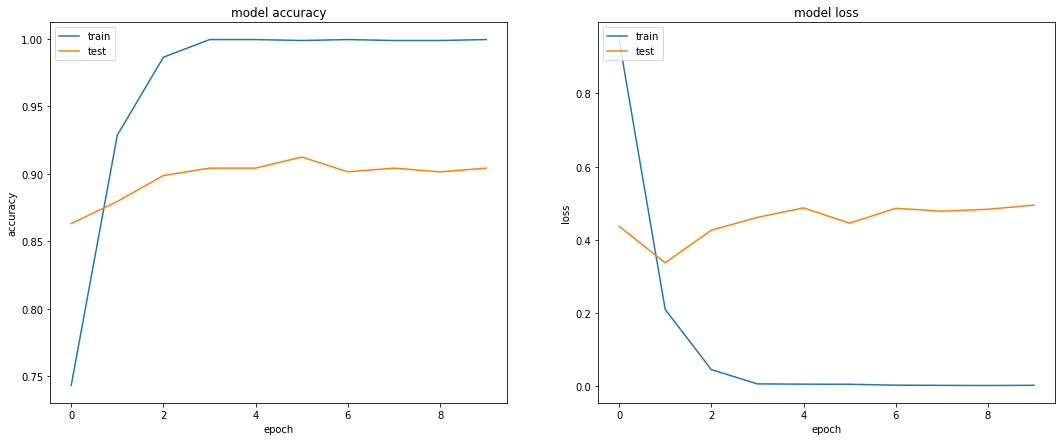

Final valid accuracy=0.904

						<<<<<<<< History of model with size=0.2 >>>>>>>>


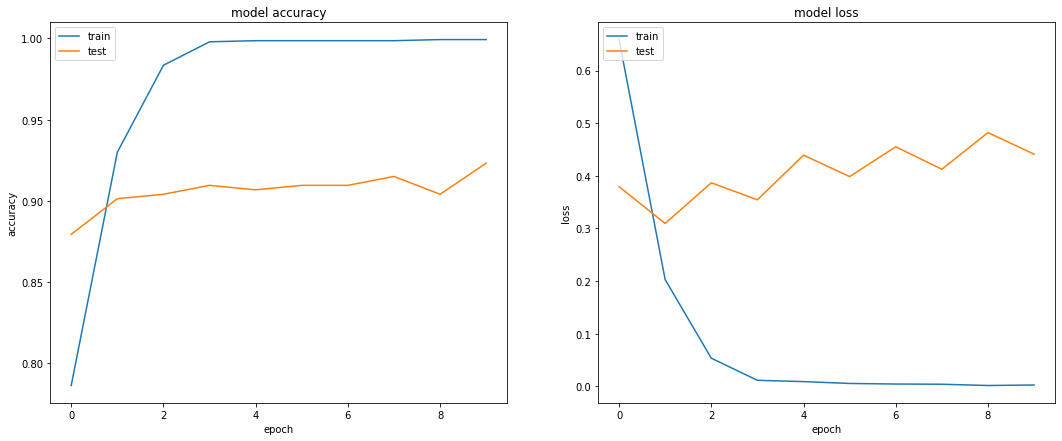

Final valid accuracy=0.923

						<<<<<<<< History of model with size=0.4 >>>>>>>>


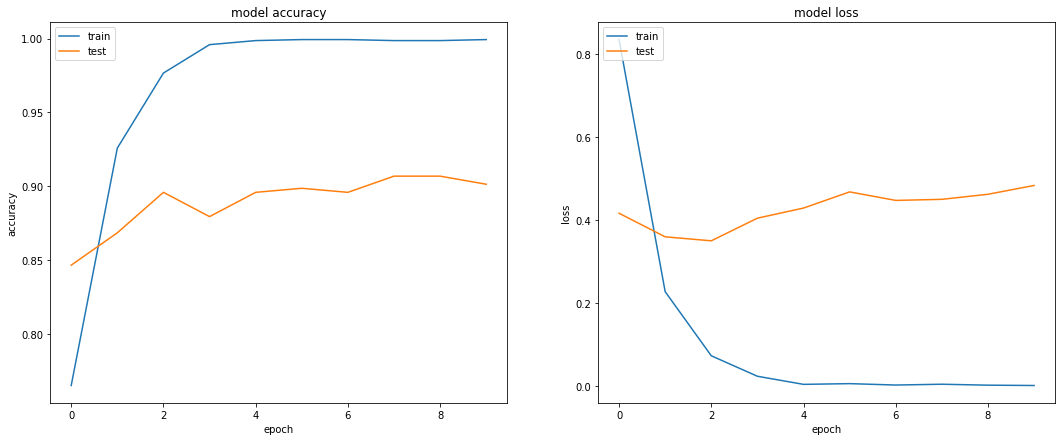

Final valid accuracy=0.901



In [ ]:
for rate in dropout_hist.keys():
  print(f'\t\t\t\t\t\t<<<<<<<< History of model with size={rate} >>>>>>>>')
  plot_history(dropout_hist[rate])
  val_acc = dropout_hist[rate].history['val_categorical_accuracy'][-1]
  print(f'Final valid accuracy={round(val_acc, 3)}\n')

**Training with dropout rate 0.2 shows best accuracy (0.923).**

## Inference

Best parameters:

*   learning rate for transfer-learning: 0.01 
*   learning rate for fine-tuning: 0.0001
*   inner size: (256, 256, 3)
*   dropout rate: 0.2

Best val accuracy: 0.923

